In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [2]:
# Code from Lars Grönberg
def multiclassScore(y: pd.Series, y_pred: pd.Series,normalize :bool = False) -> float:
    """Calculates the score according to the DMC22 evalution rules for a multiclass prediction and response

    Args:
        y (pd.Series): true y
        y_pred (pd.Series): predicted y
        normalize (bool): normalizes the score to a value in [0,1]. Defaults to false.

    Returns:
        int: Score according to the DMC22 evaluation if normalize is false.
        float: Score according to the DMC22 evaluation if normalize is true.
    
    Example:
        >>> ytrue = pd.Series([3,4,0,1,4,2])
        >>> ypred = pd.Series([4,4,0.0,0,0,3])
        >>> multiclassScore(ytrue,ypred)
        6

        >>> ytrue = pd.Series([3,4,0,1,4,2])
        >>> ypred = pd.Series([4,4,0.0,0,0,3])
        >>> multiclassScore(ytrue,ypred,normalize=True)
        0.375

        >>> ytrue = pd.Series([3,4,0,1,4,2])
        >>> ypred = pd.Series([3,4,0,1,4,2])
        >>> multiclassScore(ytrue,ypred)
        16

        >>> ytrue = pd.Series([3,4,0,1,4,2])
        >>> ypred = pd.Series([3,4,0,1,4,2])
        >>> multiclassScore(ytrue,ypred,normalize=True)
        1.0

    """

    if (y.astype(int).apply(lambda x: x in [0,1,2,3,4]).all() == False) or (y_pred.astype(int).apply(lambda x: x in [0,1,2,3,4]).all() == False) :
        raise ValueError('y and y_pred are only allowed to contain the elements 0,1,2,3,4')


    behaviourY = np.where(y>0,1,0) #1 is buying
    behaviourPredY = np.where(y_pred>0,1,0)
    correctBehaviour = np.sum(behaviourY == behaviourPredY)

    correctPredictionsWeek = np.sum((y == y_pred) & (y > 0))

    score = (correctBehaviour-correctPredictionsWeek)*1+correctPredictionsWeek*3

    if normalize == True:
        maxScore = np.sum((y>0)*3 + (y==0)*1)
        return(score/maxScore)
    else:
        return(score)


In [42]:
train_set = pd.read_csv('train_70_backgroundTrainTestsplit.csv')
test_set = pd.read_csv('test_30_backgroundTrainTestsplit.csv')

In [43]:
train_set

,userID,itemID,prediction
0,31233,21596,0.0
1,22721,31702,0.0
2,33799,18498,0.0
3,35553,2394,0.0
4,21718,10958,0.0
...,...,...,...
64238,2541,16303,1.0
64239,18879,15389,0.0
64240,4751,11906,0.0
64241,36896,28827,0.0


In [44]:
features = pd.read_csv('3_IU_FEAT_Average_Day.csv', index_col = 0).drop(columns = ['first_date_bought', 'last_date_bought'])
u_features = pd.read_csv('U_FEAT_till_3_1.csv', index_col=0)
i_features = pd.read_csv('item_features_TIMO.csv', index_col=0)
ui_train_features = pd.read_csv('train_allFeatures.csv', index_col=0, sep='|')
ui_test_features = pd.read_csv('test_allFeatures.csv', index_col=0, sep='|')
ui_train_features

,userID,itemID,cumsum,last7d,last14d,last21d,last28d,similar>0COrderSumIncl,similar>0COrderCountIncl,similar>0COrderSumExcl,similar>0COrderCountExcl,sameBrandOrderSumIncl,sameBrandOrderCountIncl,sameBrandOrderSumExcl,sameBrandOrderCountExcl,order,avg_time_orders,day_first_purchase,day_last_purchase,usage_time_items
0,1199,637,5,0.0,0.0,0.0,0.0,5,2,0,0,6,3,1,1,3,126.0,14,140,42.000000
1,21557,3520,2,0.0,0.0,0.0,0.0,3,3,1,1,3,3,1,1,1,83.0,72,155,83.000000
2,23387,1633,2,0.0,0.0,0.0,0.0,2,2,0,0,2,2,0,0,1,124.0,31,155,124.000000
3,32069,29311,5,0.0,0.0,0.0,2.0,9,7,4,4,5,3,0,0,2,28.0,135,191,21.250000
4,30359,11124,2,0.0,0.0,0.0,0.0,11,11,9,9,2,2,0,0,1,10.0,119,129,10.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64238,40754,7997,7,0.0,0.0,0.0,0.0,18,14,11,11,10,6,3,3,2,31.0,52,114,13.333333
64239,37518,18630,3,1.0,1.0,1.0,1.0,20,14,17,11,4,4,1,1,1,65.5,80,211,65.500000
64240,27676,3997,3,0.0,1.0,1.0,1.0,8,7,5,5,6,5,3,3,1,127.0,77,204,63.500000
64241,42405,28532,2,0.0,0.0,0.0,0.0,17,14,15,12,3,3,1,1,1,115.0,34,149,115.000000


In [45]:
u_features

,userID,u_EF,u_avg_orders,u_avg_period,u_first_bought,u_last_bought,u_std_avg_period,u_mean_bought,u_std_bought
0,0,6,1.00,27.00,5,194,17.94,115.75,62.77
14,1,6,1.23,22.38,37,216,14.02,138.00,53.28
27,2,7,1.20,21.62,29,202,11.63,120.78,57.42
47,3,6,1.29,15.54,10,212,12.91,106.71,63.85
85,4,6,1.71,20.11,1,182,10.77,84.90,64.02
...,...,...,...,...,...,...,...,...,...
919611,46133,3,1.10,23.75,80,175,19.52,132.60,34.76
919632,46134,5,1.22,35.00,56,196,11.64,130.60,48.45
919659,46135,3,1.86,21.33,126,190,13.20,161.00,22.87
919666,46136,6,1.97,23.22,2,211,12.20,103.50,65.14


In [49]:
ui_features = pd.concat([ui_train_features, ui_test_features], axis=0)
ui_features

,userID,itemID,cumsum,last7d,last14d,last21d,last28d,similar>0COrderSumIncl,similar>0COrderCountIncl,similar>0COrderSumExcl,similar>0COrderCountExcl,sameBrandOrderSumIncl,sameBrandOrderCountIncl,sameBrandOrderSumExcl,sameBrandOrderCountExcl,order,avg_time_orders,day_first_purchase,day_last_purchase,usage_time_items
0,1199,637,5,0.0,0.0,0.0,0.0,5,2,0,0,6,3,1,1,3,126.000000,14,140,42.000000
1,21557,3520,2,0.0,0.0,0.0,0.0,3,3,1,1,3,3,1,1,1,83.000000,72,155,83.000000
2,23387,1633,2,0.0,0.0,0.0,0.0,2,2,0,0,2,2,0,0,1,124.000000,31,155,124.000000
3,32069,29311,5,0.0,0.0,0.0,2.0,9,7,4,4,5,3,0,0,2,28.000000,135,191,21.250000
4,30359,11124,2,0.0,0.0,0.0,0.0,11,11,9,9,2,2,0,0,1,10.000000,119,129,10.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27529,2176,9773,2,0.0,0.0,0.0,0.0,5,5,3,3,4,4,2,2,1,42.000000,138,180,42.000000
27530,20041,19824,4,0.0,0.0,0.0,0.0,4,4,0,0,4,4,0,0,1,53.333333,25,185,53.333333
27531,39920,18714,4,0.0,0.0,0.0,0.0,4,2,0,0,4,2,0,0,2,159.000000,23,182,79.500000
27532,5127,1299,3,1.0,1.0,1.0,1.0,6,6,3,3,5,5,2,2,1,47.500000,118,213,47.500000


## Merging X_train, X_test with features

In [57]:
X_train = train_set.merge(ui_features, how = 'left', on = ['userID', 'itemID']).merge(u_features, how = 'left', on ='userID')
X_test = (test_set.merge(ui_features, how = 'left', on = ['userID', 'itemID'])).merge(u_features, how = 'left', on ='userID')
#X_train = ui_train_features.merge(u_features, how = 'left', on ='userID')
#X_test = ui_test_features.merge(u_features, how = 'left', on ='userID')
X_train


,userID,itemID,prediction,cumsum,last7d,last14d,last21d,last28d,similar>0COrderSumIncl,similar>0COrderCountIncl,...,day_last_purchase,usage_time_items,u_EF,u_avg_orders,u_avg_period,u_first_bought,u_last_bought,u_std_avg_period,u_mean_bought,u_std_bought
0,31233,21596,0.0,2,0.0,0.0,0.0,1.0,13,7,...,189,117.000000,4,1.64,36.20,8,189,24.49,102.00,73.54
1,22721,31702,0.0,6,0.0,0.0,0.0,0.0,19,13,...,179,47.333333,6,1.76,13.92,33,214,10.22,116.14,63.50
2,33799,18498,0.0,3,0.0,0.0,0.0,0.0,14,10,...,150,68.000000,6,1.26,20.89,14,202,18.16,105.10,63.30
3,35553,2394,0.0,2,0.0,0.0,0.0,1.0,2,2,...,194,105.000000,6,1.19,27.33,30,194,14.14,102.14,53.13
4,21718,10958,0.0,2,0.0,0.0,0.0,0.0,8,8,...,168,146.000000,7,1.09,18.50,22,207,12.80,117.91,60.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64238,2541,16303,1.0,2,0.0,0.0,0.0,0.0,2,2,...,161,83.000000,5,1.26,17.25,3,210,14.67,107.23,68.90
64239,18879,15389,0.0,3,0.0,0.0,0.0,0.0,3,2,...,181,85.000000,6,1.22,28.00,13,181,17.52,104.14,54.52
64240,4751,11906,0.0,5,1.0,1.0,1.0,1.0,5,5,...,210,47.000000,7,1.42,17.00,6,210,6.79,112.00,62.34
64241,36896,28827,0.0,6,0.0,0.0,0.0,1.0,7,7,...,195,38.400000,7,1.43,16.00,3,195,7.71,105.85,60.06


In [58]:
ui_train_features[(ui_train_features['userID'] == 33799) & (ui_train_features['itemID'] == 18498)]

,userID,itemID,cumsum,last7d,last14d,last21d,last28d,similar>0COrderSumIncl,similar>0COrderCountIncl,similar>0COrderSumExcl,similar>0COrderCountExcl,sameBrandOrderSumIncl,sameBrandOrderCountIncl,sameBrandOrderSumExcl,sameBrandOrderCountExcl,order,avg_time_orders,day_first_purchase,day_last_purchase,usage_time_items


## Split train_set and test_set into X_train, y_train, X_test and y_test

In [59]:
y_train = X_train['prediction']
y_test = X_test['prediction']

## Building model with unbalanced training data. 

In [61]:
# Using random forest model
forest = RandomForestClassifier()
# applying GridSearchCV
params = {'criterion': ['gini', 'entropy'],
         'n_estimators': np.arange(100, 104),
         'min_samples_split': np.arange(5, 8),
         'max_depth': np.arange(16, 19)}
clf = GridSearchCV(estimator = forest, param_grid = params, error_score = 'raise', n_jobs=-1)
clf.fit(X_train.drop('prediction', axis=1), y_train)
clf.best_params_

{'criterion': 'entropy',
 'max_depth': 17,
 'min_samples_split': 5,
 'n_estimators': 101}

In [62]:
y_pred = clf.predict(X_test.drop('prediction', axis=1))

In [63]:
cm = confusion_matrix(y_test, y_pred)
ac = accuracy_score(y_test, y_pred)
print(cm)
print(f'Accuracy score: {ac}')

[[22528     6     3     2     0]
 [ 1305    25     6     1     0]
 [ 1139    13    12     0     0]
 [ 1188     8     4     3     0]
 [ 1284     1     1     0     5]]
Accuracy score: 0.8198227645819713


## Random Undersampling

### Deleting randomly rows in training data which have 0_prediction , so that getting a balanced training data between 0_prediction and other predictions


In [16]:
amount_0 = X_train[X_train['prediction'] == 0].shape[0]
amount_1 = X_train[X_train['prediction'] == 1].shape[0]
amount_2 = X_train[X_train['prediction'] == 2].shape[0]
amount_3 = X_train[X_train['prediction'] == 3].shape[0]
amount_4 = X_train[X_train['prediction'] == 4].shape[0]

total_unlike_0 = amount_1 + amount_2 + amount_3 + amount_4
print(f'0: {amount_0}\t\t1: {amount_1}\t\t2: {amount_2}\t\t3: {amount_3}\t\t4: {amount_4}')
# reduce randomly amount of 0 prediction in training data
df_0_under = X_train[X_train['prediction'] == 0].sample(total_unlike_0, random_state = 1)

X_train_balanced = pd.concat([df_0_under, X_train.drop(X_train[X_train['prediction'] == 0].index)]).sample(frac = 1)
X_train_balanced['prediction'].value_counts()


0: 52883		1: 3030		2: 2677		3: 2798		4: 2855


0.0    11360
1.0     3030
4.0     2855
3.0     2798
2.0     2677
Name: prediction, dtype: int64

## Fit model with undersampling traing data

In [17]:
clf.fit(X_train_balanced.drop('prediction', axis = 1), X_train_balanced['prediction'])
clf.best_params_

{'criterion': 'entropy',
 'max_depth': 16,
 'min_samples_split': 5,
 'n_estimators': 104}

In [18]:
y_pred_balanced = clf.predict(X_test.drop('prediction', axis=1))

In [19]:
cm_balanced = confusion_matrix(y_test, y_pred_balanced)
ac_balanced = accuracy_score(y_test, y_pred_balanced)
score_balanced = multiclassScore(y_test, pd.Series(y_pred_balanced))
print(cm_balanced)
print(f'Accuracy score: {ac_balanced}')
print(f'DMC score: {score_balanced}')

[[21310   551   177   218   283]
 [ 1014   219    46    37    21]
 [  877   142    69    41    35]
 [  913   112    48    73    57]
 [ 1079    85    27    31    69]]
Accuracy score: 0.7895692598242173
DMC score: 23282


## Random Oversampling

### Duplicating randomly rows in training data which have 1_, 2_ , 3_, or 4_prediction , so that getting a balanced training data between 0_prediction and other predictions


In [64]:
amount_0 = X_train[X_train['prediction'] == 0].shape[0]
amount_1 = X_train[X_train['prediction'] == 1].shape[0]
amount_2 = X_train[X_train['prediction'] == 2].shape[0]
amount_3 = X_train[X_train['prediction'] == 3].shape[0]
amount_4 = X_train[X_train['prediction'] == 4].shape[0]

unlike_0 = amount_1 + amount_2 + amount_3 + amount_4

ratio1 = amount_1 / unlike_0
ratio2 = amount_2 / unlike_0
ratio3 = amount_3 / unlike_0
ratio4 = amount_4 / unlike_0

print(f"0: {amount_0}\t\t1: {amount_1}\t\t2: {amount_2}\t\t3: {amount_3}\t\t4: {amount_4}")

df_1_under = X_train[X_train['prediction'] == 1].sample(round(ratio1 * amount_0), replace=True)
df_2_under = X_train[X_train['prediction'] == 2].sample(round(ratio2 * amount_0), replace=True)
df_3_under = X_train[X_train['prediction'] == 3].sample(round(ratio3 * amount_0), replace=True)
df_4_under = X_train[X_train['prediction'] == 4].sample(round(ratio4 * amount_0), replace=True)

X_train_balanced_over = pd.concat([df_1_under, df_2_under, df_3_under, df_4_under, X_train[X_train['prediction'] == 0]], axis=0)

X_train_balanced_over['prediction'].value_counts()

0: 52883		1: 3030		2: 2677		3: 2798		4: 2855


0.0    52883
1.0    14105
4.0    13291
3.0    13025
2.0    12462
Name: prediction, dtype: int64

### Fit model with Oversampling traing data

In [70]:
from sklearn.inspection import permutation_importance

In [65]:
# Using random forest model
forest_over = RandomForestClassifier()
# applying GridSearchCV
params = {'criterion': ['gini', 'entropy'],
         'n_estimators': np.arange(100, 104),
         'min_samples_split': np.arange(5, 8),
         'max_depth': np.arange(16, 19)}
clf_over = GridSearchCV(estimator = forest_over, param_grid = params, error_score = 'raise', n_jobs=-1)
clf_over.fit(X_train_balanced_over.drop(columns=['prediction']), X_train_balanced_over['prediction'])
clf_over.best_params_

{'criterion': 'entropy',
 'max_depth': 18,
 'min_samples_split': 5,
 'n_estimators': 102}

In [67]:
y_pred_balanced_over = clf_over.predict(X_test.drop('prediction', axis=1))

In [68]:
cm_balanced_over = confusion_matrix(y_test, y_pred_balanced_over)
ac_balanced_over = accuracy_score(y_test, y_pred_balanced_over)
score_balanced_over = multiclassScore(y_test, pd.Series(y_pred_balanced_over))
print(cm_balanced_over)
print(f'Accuracy score: {ac_balanced_over}')
print(f'DMC score: {score_balanced_over}')

[[22249   183    42    34    31]
 [ 1160   146    20     9     2]
 [ 1025    65    58     7     9]
 [ 1080    57    14    46     6]
 [ 1207    31     6     7    40]]
Accuracy score: 0.8185879276530834
DMC score: 23352


### Plotting the importances of features

<AxesSubplot:>

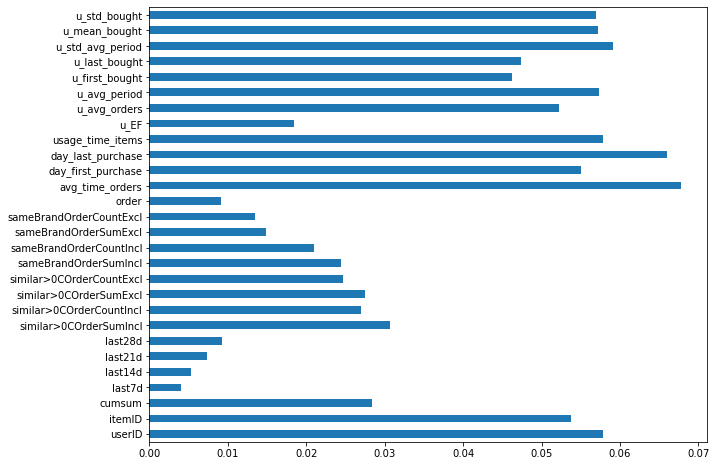

In [69]:
final_forest = clf_over.best_estimator_
plt.figure(figsize = (10, 8))
pd.Series(final_forest.feature_importances_, index = X_train_balanced_over.drop('prediction', axis=1).columns).plot(kind = 'barh')


In [72]:
temp = permutation_importance(final_forest,X_test.drop('prediction', axis=1), X_test.loc[:,'prediction'] )


In [85]:
feature_names = [f"feature {i}" for i in X_test.drop('prediction', axis=1).columns]

In [1]:
plt.figure(figsize=(10, 8))
pd.Series(temp['importances_mean'], index=feature_names).plot.barh(yerr=temp.importances_std)
plt.savefig('features importance permutation.jpg', pad_inches=1)
plt.show()

NameError: name 'plt' is not defined

In [78]:
temp

{'importances_mean': array([ 1.08956200e-03,  3.48659839e-04, -3.34132345e-04, -1.08956200e-04,
        -3.63187332e-04,  5.08462265e-05,  6.31945958e-04, -2.90549866e-05,
        -9.37023317e-04, -2.10648653e-04, -1.74329919e-04, -1.22757318e-03,
        -8.64385850e-04, -3.05077359e-04, -2.90549866e-04, -2.17912399e-05,
         5.81099731e-05, -2.61494879e-04,  6.90055931e-04, -5.30253505e-04,
        -4.35824798e-05,  6.02890971e-04,  5.81099731e-05,  1.45274933e-04,
         1.00966078e-03,  1.96121159e-04,  1.52538679e-04,  4.50352292e-04]),
 'importances_std': array([2.23883708e-04, 3.24519618e-04, 4.50937697e-04, 2.66887093e-04,
        2.64902775e-04, 1.90249159e-04, 1.37052098e-04, 2.04677894e-04,
        9.01407253e-05, 8.40839464e-05, 1.72504425e-04, 1.95447433e-04,
        4.82588371e-04, 1.55111183e-04, 2.04161681e-04, 2.01036573e-04,
        2.78117088e-04, 1.89971625e-04, 2.15477547e-04, 2.43741726e-04,
        2.54127343e-04, 3.59243496e-04, 3.09541305e-04, 1.96255627e